In [2]:
from pathlib import Path
import requests

# get the dataset
DATA_PATH = Path('data')
PATH = DATA_PATH / 'mnist'

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [3]:
import pickle
import gzip

# train and test sets are already done
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid),_) = pickle.load(f, encoding="latin-1")
    
print(x_train.shape)
print(y_train.shape)

(50000, 784)
(50000,)


tensor(2)


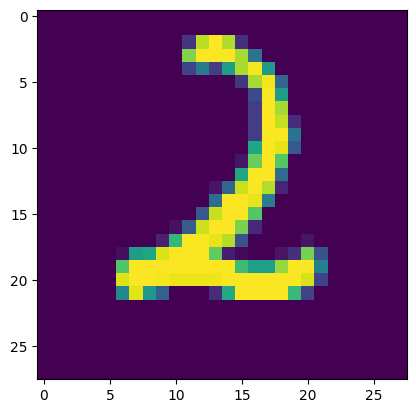

In [13]:
from matplotlib import pyplot

pyplot.imshow(x_train[122].reshape((28, 28)), cmap="viridis")
print(y_train[122])

In [5]:
import torch

# turn numpy arrays to tensors that give a better performance
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

In [6]:
# initialize weight and bias
import math

torch.manual_seed(12) # creates the same random numbers for debugging
weights = torch.randn(784, 10) / math.sqrt(784) # Xavier initialization
weights.requires_grad_() # add a gradient to the tensors # _ means in-place apply, saves memory
bias = torch.zeros(10, requires_grad=True)

In [7]:
# define our model: input -> model -> output
# xb = x batch
def model(xb):
	return xb @ weights + bias

In [8]:
# Loss function

def softmax(x): # e^x_i / sum(e^x_i)
	return x.exp() / x.exp().sum(-1).unsqueeze(-1) # unsqueze restores dimension

def cross_entropy_loss(pred, targets):
	bs, out_features = pred.shape
	one_hot_encoded_targets = torch.eye(out_features)[targets] # creates the one hot encoded matrix from vectors
	# - 1/n sum p * log(q) -> n = bs
	return -(one_hot_encoded_targets * softmax(pred).log()).sum() / bs # sum all and take average of the batch

loss_func = cross_entropy_loss
# print(softmax(model(x_train)).shape)

In [9]:
import torch.nn.functional as F

# test cross entropy loss implementation
bs = 64

xb = x_train[0:bs]
pred = model(xb)
yb = y_train[0:bs]

print(F.cross_entropy(pred, yb))
print(f'loss={cross_entropy_loss(pred, yb)}')

tensor(2.3215, grad_fn=<NllLossBackward0>)
loss=2.3214573860168457


In [10]:
# Accuracy: how many of the batches we get correct
def accuracy_func(pred, yb):
	pred_class = torch.argmax(pred, dim=1) # argmax returns the largest number index in an array
	return (pred_class == yb).float().mean()

In [11]:
# train the model

epochs = 2
n = x_train.shape[0]
num_batches = n // bs + 1

lr = 0.5

for epoch in range(epochs):
	for i in range(num_batches):
		start_i = i * bs
		end_i = start_i + bs

		xb = x_train[start_i:end_i]
		yb = y_train[start_i:end_i]
		
		pred = model(xb)

		accuracy = accuracy_func(pred, yb)

		loss = loss_func(pred, yb)
		loss.backward() # autograd

		with torch.no_grad(): # we already computed the grad, set all requires_grad flags to false -> reduces memory consumption
			weights -= weights.grad * lr
			bias -= bias.grad * lr
			weights.grad.zero_() # prevent gradient accumulation, recalculate every time for the new weights
			bias.grad.zero_()
		
		# logging
		if i % 100 == 0:
			train_loss, train_accuracy = loss.item(), accuracy.item() * 100
			print(f'loss: {train_loss:6f} accuracy: {train_accuracy: 0.1f}%')

loss: 2.321457 accuracy:  14.1%
loss: 0.312502 accuracy:  89.1%
loss: 0.298902 accuracy:  89.1%


loss: 0.390776 accuracy:  93.8%
loss: 0.232407 accuracy:  90.6%
loss: 0.380827 accuracy:  89.1%
loss: 0.265795 accuracy:  89.1%
loss: 0.379751 accuracy:  90.6%
loss: 0.280699 accuracy:  92.2%
loss: 0.259951 accuracy:  92.2%
loss: 0.193850 accuracy:  90.6%
loss: 0.344282 accuracy:  92.2%
loss: 0.208628 accuracy:  93.8%
loss: 0.355668 accuracy:  90.6%
loss: 0.228148 accuracy:  90.6%
loss: 0.361645 accuracy:  89.1%
